## Test models
With smart_open load corpus. From corpus take articles. Article has title and content. Take sample words from aticle as sample document. Get document vector from model and find most similar docs from corpus with model method most_similar. If article title in most_similar result - count as success. Custom metric: rate = cumulative success count / articles count.

In case of running notebook on Google Colab environment with Google Drive storage:

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
# replace path with parent directory of current notebook
%cd /content/drive/MyDrive/Colab\ Notebooks/s2v_d2v/

Mounted at /content/drive
/content/drive/MyDrive/Colab Notebooks/s2v_d2v


In [ ]:
!pip install -r requirements.txt

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 13.7 MB 4.3 MB/s 
     |████████████████████████████████| 24.1 MB 1.3 MB/s 
     |████████████████████████████████| 5.8 MB 24.2 MB/s 
     |████████████████████████████████| 10.1 MB 49.3 MB/s 
     |████████████████████████████████| 660 kB 57.3 MB/s 
  Created wheel for en-core-web-sm: filename=en_core_web_sm-3.0.0-py3-none-any.whl size=13704318 sha256=7ff7cca28bb2c3a9ec55778381c50dd641e1b1bfa8705e17e3d9ca32a4b34738
  Stored in directory: /root/.cache/pip/wheels/2d/86/ba/c33ceff8af5cb8a963e86131912039d39b37227f9787661bca
Successfully built en-core-web-sm
  Attempting uninstall: typing-extensions
    Found existing installation: typing-extensions 4.1.1
    Uninstalling typing-extensions-4.1.1:
      Successfully uninstalled typing-extensions-4.1.1
  Attempting uninstall: typer
    Found existing installation: typer 0.4.2
    Uninstalling typer-0.4.2:

In [ ]:
from gensim.models.doc2vec import Doc2Vec
import smart_open
import pickle
import random
import tarfile
import pandas as pd
import matplotlib.pyplot as plt

Uncompress models archive:

In [ ]:
with tarfile.open('models.tar.gz', "r:gz") as tar:
        tar.extractall()

In [ ]:
# load saved models
model_dbow = Doc2Vec.load('models/doc2vec_dbow.model')
model_dmm = Doc2Vec.load('models/doc2vec_dmm.model')
model_dmc = Doc2Vec.load('models/doc2vec_dmc.model')

Check any model. View first doc title:

In [ ]:
print(model_dbow.dv.index_to_key[0])

David Stagg


View first doc vector:

In [ ]:
print(model_dbow.dv[0])

[-3.02440107e-01 -2.15882994e-02 -1.67690665e-01  7.46002495e-02
 -8.81250389e-03 -4.07685310e-01 -3.29972535e-01 -1.05294036e-02
 -2.31629193e-01 -1.57151237e-01 -1.79090425e-01 -3.40554953e-01
  2.96637654e-01  2.81877425e-02 -8.26067850e-02 -7.16667473e-01
  3.86951894e-01  2.62753069e-01  1.01038935e-02 -2.75535852e-01
  4.93677050e-01 -4.54109937e-01 -2.81042457e-01 -3.93378809e-02
  7.07709193e-01 -1.41847311e-02  4.06730026e-02  5.85631803e-02
 -1.54891023e-02  1.05214760e-01 -1.75613657e-01  7.22017810e-02
 -1.20682023e-01  1.41018167e-01  1.38056785e-01 -1.95675761e-01
  1.67595044e-01 -7.05182374e-01 -3.05746379e-03  2.92971671e-01
  2.38685280e-01 -5.23874462e-01  1.99213266e-01 -3.63476425e-02
 -2.28174515e-02 -5.90328693e-01  3.95642847e-01  1.56809941e-01
 -3.10298689e-02  6.12699315e-02 -1.85257971e-01 -3.17928135e-01
  3.61607611e-01 -1.72615364e-01  1.32603645e-01 -5.56700975e-02
 -2.39916518e-01  1.40195973e-02 -1.68341529e-02 -2.97449296e-03
 -1.34181723e-01  5.45882

Most similar docs for that vector:

In [ ]:
print(model_dbow.dv.most_similar([model_dbow.dv[0]]))

[('David Stagg', 1.0), ('Danny Nutley', 0.6895224452018738), ('Kevin Kingston', 0.6455857157707214), ('Matt Bickerstaff', 0.6419275403022766), ('Colin Best', 0.6391711831092834), ('James Byrne (footballer)', 0.6368783712387085), ('Luke Harlen', 0.636198878288269), ('Aaron Gorrell', 0.6334865689277649), ('Brett Ebert', 0.6321484446525574), ('Luke Priddis', 0.6288036108016968)]


Define custom metric function:

In [ ]:
def custom_metric(model, wiki_text_path, mode=0, topn=1):
    # mode 0 - all set of words; 0 < mode < 1 - set lenght share (1/3); >=1 - n words from doc
    docs_count = 0
    success_count = 0
    for line in smart_open.open(wiki_text_path, encoding='utf8'):
        title, words = line.split('\t')
        words=words.split()

        if mode >= 1:
            test_set = random.sample(set(words), min(round(mode),len(set(words))))
        elif (mode > 0 and mode < 1):
            test_set = random.sample(set(words), round(len(set(words))*mode))
        else:
            test_set = list(set(words))

        match_top = model.dv.most_similar([model.infer_vector(test_set)], topn=topn)
        if (title in [ out[0] for out in match_top ]):
            success_count += 1
            
        docs_count += 1

        # for test only
        if docs_count <= 5:
          print('title :', title)
          print('words :', test_set)
          print('topn', match_top)
          print('cumulative success count ', success_count, '/', docs_count)
        #if docs_count % 50000 == 0:
        #  print('processed docs:', docs_count)
    return success_count/docs_count

In [ ]:
# wiki corpus path
wiki_text_path = 'corpus/wiki.txt.gz'

Calculate custom metric for all models:

In [ ]:
for model in [model_dbow, model_dmm, model_dmc]:
    print(model)
    random.seed(1)
    print('\nrate: ', custom_metric(model, wiki_text_path, mode=10, topn=10))
    print('\n')

Doc2Vec<dbow+w,d300,n5,w3,mc20,s0.001,t7>
title : David Stagg
words : ['loss|NOUN', 'victory|NOUN', 'Personal|ADJ', '24|CARDINAL', 'Queensland|GPE', 'preliminary|ADJ', 'injury|NOUN', 'Origin|PROPN', '27|CARDINAL', 'new|ADJ']
topn [('David Stagg', 0.6763937473297119), ('Gary Wurth', 0.6170538663864136), ('Brett Ebert', 0.6006390452384949), ('Danny Nutley', 0.5976786017417908), ('Colin Best', 0.592360258102417), ('Brett Studman', 0.5873605608940125), ('Graham Johncock', 0.5758448839187622), ('Matt Bickerstaff', 0.5729566812515259), ('Matt Johnston', 0.5714712142944336), ('Kevin Kingston', 0.5702523589134216)]
cumulative success count  1 / 1
title : Utica Psychiatric Center
words : ['Wings|ORG', 'English|LANGUAGE', 'slats|NOUN', '20|CARDINAL', 'director|NOUN', 'MVPC|PROPN', 'journal|NOUN', 'set|VERB', 'practice|NOUN', 'describes|VERB']
topn [('Mobile Computing and Communications Review', 0.4664691984653473), ('Iranian Studies (journal)', 0.46619632840156555), ('NetCDF Operators', 0.459447

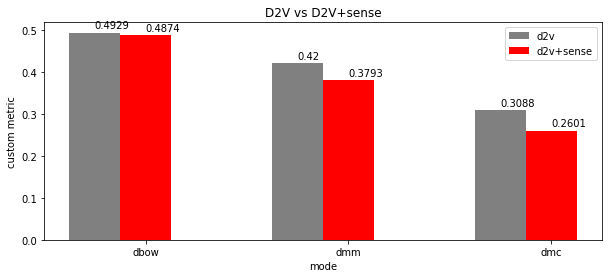

In [4]:
import numpy as np
import matplotlib.pyplot as plt

barWidth = 0.25
fig = plt.subplots(figsize =(10, 4))

d2v = [0.4929,0.4200,0.3088]
d2v_sense = [0.4874,0.3793,0.2601]

br1 = np.arange(len(d2v))
br2 = [x + barWidth for x in br1]

plt.bar(br1, d2v, color ='grey', width = barWidth, label ='d2v')
plt.bar(br2, d2v_sense, color ='r', width = barWidth, label ='d2v+sense')

plt.xlabel('mode')
plt.ylabel('custom metric')
plt.xticks([r + barWidth for r in range(len(d2v))],['dbow', 'dmm', 'dmc'])
#plt.ylim([0.3, 0.6])

for i in range(len(d2v)):
    plt.text(i,d2v[i]+.01,d2v[i])
for i in range(len(d2v_sense)):
    plt.text(i+ barWidth,d2v_sense[i]+.01,d2v_sense[i])

plt.title('D2V vs D2V+sense')
plt.legend()
plt.show()

In [ ]:
!rm -rf 'models'